<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Tejas/Deep_Learning_HW5_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 5

References:


*   https://www.tensorflow.org/api_docs/python/tf/image/extract_patches
*   https://blog.whidev.com/split-image-tiles-python/ (Didnt use as it requires input of jpeg or png type)
*   https://www.tensorflow.org/api_docs/python/tf/expand_dims
*   https://numpy.org/doc/stable/reference/generated/numpy.where.html ( np.where)
*   https://stackoverflow.com/questions/50463092/is-there-a-tensorflow-equivalent-to-np-empty (tf.zeros)
*   https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html












##GPU Check

In [1]:
#Path: TensorFlow/Tejas/
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [3]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.292953050999998
GPU (s):
0.04111255899999833
GPU speedup over CPU: 80x


##Dependencies

In [4]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten
from librosa.core import stft,istft
import soundfile as sf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

##Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = (X_train.astype("float32")) / 255.0
X_test = (X_test.astype("float32")) / 255.0
     

11490434/11490434 [==============================] - 2s 0us/step


In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
X_test.shape

(10000, 28, 28)

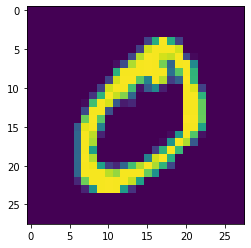

In [9]:
plt.imshow(X_train[1])

In [10]:
num_samples = X_train.shape[0]
print(num_samples)

60000


In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
X_train[1,:,:].shape

# We can pass images then 
#just expand dims at 0 and -1

(28, 28)

In [13]:
# tf.expand_dims( )

In [14]:
# output = tf.image.extract_patches( images = X_train[0],
#                            sizes=[1, 7, 7, 1],
#                            strides=[1, 7, 7, 1],
#                            rates=[1, 1, 1, 1],
#                            padding='VALID')

###Function to make Image Tiles

In [15]:
def image_patches(pic):
  pic = tf.expand_dims(pic,axis=0)
  pic = tf.expand_dims(pic, axis = -1)
  #print(pic.shape)
  output = tf.image.extract_patches( images = pic,
                           sizes=[1, 7, 7, 1],
                           strides=[1, 7, 7, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
  #print(type(output))
  stream_tiles = tf.reshape(output,shape=(16,7,7))
  #stream_tiles = tf.reshape(stream_tiles, shape = (16,7,7))
  return stream_tiles

###Code Engine to make the tiles on the dataset

In [16]:
image_tiles = []
for i in range(X_train.shape[0]):
    image_tiles.append(image_patches(X_train[i,:,:]))
image_tiles_tr = np.array(image_tiles)
print(image_tiles_tr.shape)

(60000, 16, 7, 7)


###Visualize the tiles

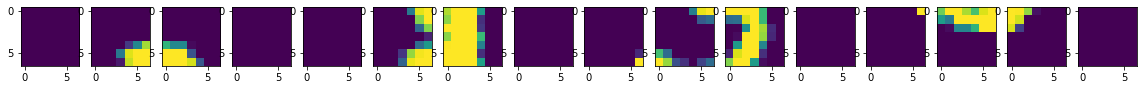

In [17]:
fig, ax = plt.subplots(1,16, figsize=(20,20))

for i in range(4):
  for j in range(4):
    ax[4*i + j].imshow(image_tiles_tr[10][4*i+j])

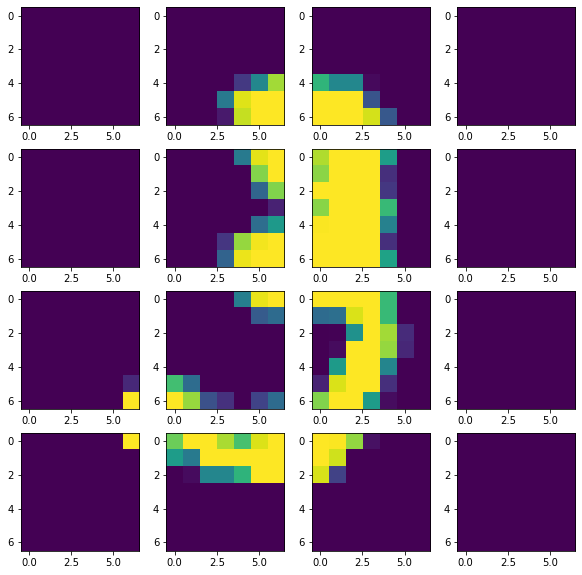

In [18]:
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(10,10))
for i in range(4):
  for j in range(4):
    ax[i,j].imshow(image_tiles_tr[10][4*i+j])


###Vectorize the tiles

In [19]:
# While I’ll keep the same order, to simplify our model architecture,
#  we will vectorize each patch from 7×7 to a 49-dimensional vector. Finally, our sequence is a matrix X ∈ R16×49, where 16 is the number of “time” steps. 
# This is an input sequence to your RNN for training
# So internally its literally an image in its numeric form

vec_tiles_tr = image_tiles_tr.reshape(X_train.shape[0],-1,49)

In [20]:
vec_tiles_tr.shape

(60000, 16, 49)

In [21]:
vec_tiles_tr[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0. 

###Model

Just **added Dropout** after first layer to professors architecture. I felt dropout would improve the training, tradeoff I feel is more number o0f epochs. Thats fine.

After learning each datapoint its supposed to predict how the next datapoint will be like. ( Here datapoint is an image )

####Data tuning

In [22]:
X_tr_tile = image_tiles_tr[:,:15,:]
#X_tr_tile = tf.reshape(X_tr_tile,shape=(-1,49))

X_tr_tile = tf.reshape(X_tr_tile,shape=(X_train.shape[0],-1,49))

In [23]:
X_tr_tile.shape

TensorShape([60000, 15, 49])

In [24]:
y_tr_tile = image_tiles_tr[:,1:16,:]
y_tr_tile = tf.reshape(y_tr_tile,shape=(X_train.shape[0],-1,49))

In [25]:
y_tr_tile.shape

TensorShape([60000, 15, 49])

####Model Arc

In [31]:
#Followed profssors model architecture just added Dropout
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, 49)),
    tf.keras.layers.LSTM(64,return_sequences=True, activation = 'tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64,return_sequences=True, activation = 'tanh'),
    tf.keras.layers.Dense(units=49, activation = 'relu')
  ])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 64)          29184     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense_1 (Dense)             (None, None, 49)          3185      
                                                                 
Total params: 65,393
Trainable params: 65,393
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss= 'mse'
)

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [35]:
model.fit(X_tr_tile,y_tr_tile,batch_size = 100,epochs = 100,validation_split = 0.2, callbacks=callback)

Epoch 1/100
480/480 [==============================] - 6s 8ms/step - loss: 0.0679 - val_loss: 0.0494
Epoch 2/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0469 - val_loss: 0.0422
Epoch 3/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0421 - val_loss: 0.0389
Epoch 4/100
480/480 [==============================] - 4s 8ms/step - loss: 0.0395 - val_loss: 0.0370
Epoch 5/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0379 - val_loss: 0.0357
Epoch 6/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0368 - val_loss: 0.0348
Epoch 7/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0360 - val_loss: 0.0343
Epoch 8/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0353 - val_loss: 0.0337
Epoch 9/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0348 - val_loss: 0.0331
Epoch 10/100
480/480 [==============================] - 4s 7ms/step - loss: 0.0344 - val_lo

In [36]:
# tf.keras.models.save_model(
#     model,
#     filepath,
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True
# )

model.save(filepath = '/content/drive/MyDrive/ENGR-E-533 /DATA/HW5/Q1model.hdf5')

In [26]:
#https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model

model = tf.keras.models.load_model(filepath = '/content/drive/MyDrive/ENGR-E-533 /DATA/HW5/Q1model.hdf5')

####Data Tune y_train

In [27]:
y_test.shape

(10000,)

In [28]:
y_train.shape

(60000,)

In [29]:
X_test.shape

(10000, 28, 28)

In [30]:
y_trial = []
for i in range(X_test.shape[0]):
    y_trial.append(image_patches(X_test[i,:,:]))
y_trial_tr = np.array(y_trial)
print(y_trial_tr.shape)

(10000, 16, 7, 7)


In [31]:
y_trial_tr.shape

(10000, 16, 7, 7)

In [32]:
y_trial = tf.reshape(y_trial_tr,shape=(X_test.shape[0],16,49))

In [33]:
y_trial.shape

TensorShape([10000, 16, 49])

###Lets see output with just one half 

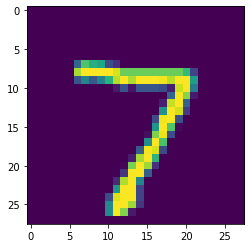

In [34]:
#visual = y_trial.reshape()
plt.imshow(X_test[0])

In [35]:
tiles = y_trial[0][:8,:]

In [36]:
tiles.shape

TensorShape([8, 49])

In [37]:
tiles = tf.expand_dims(tiles,axis=0)
for i in range(8):
  pred = model.predict(tiles)
  tiles = np.concatenate((tiles, pred[:,-1,:].reshape(1,1,49)),axis = 1)


1/1 [==============================] - 0s 17ms/step


In [38]:
tiles.shape

(1, 16, 49)

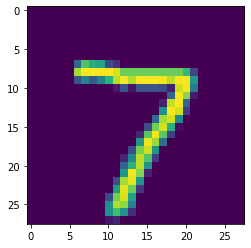

In [39]:
recreated_image = np.zeros((28,28))
count = 0
for i in range(4):
    for j in range(4):
        recreated_image[i*7:i*7+7,j*7:j*7+7] = tiles[0,count].reshape(7,7)
        count+=1
plt.imshow(recreated_image)

###Lets Scale this


Lets find indexes of nubers from 0-10 from our y_trial.

Store these index values in a diff array.

then reconstruct them 

In [40]:
X_test.shape

(10000, 28, 28)

In [41]:
y_trial.shape

TensorShape([10000, 16, 49])

Fetch data from those index

In [42]:
data_index = np.zeros((100,28,28))
ten_index = []
for i in range(0,10):
  index = np.where(y_test == i)
  #print(index[:10])
  for i in range(10):

    ten_index.append(index[0][i])
  
  #print(type(ten_index))
  print(ten_index)
  #data_index.append(ten_index.item())
  
for i in range(10):
  for j in range(10):
    data_index[i*10+j] = X_test[ten_index[i*10+j]]
  
  

[3, 10, 13, 25, 28, 55, 69, 71, 101, 126]
[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 2, 5, 14, 29, 31, 37, 39, 40, 46, 57]
[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 2, 5, 14, 29, 31, 37, 39, 40, 46, 57, 1, 35, 38, 43, 47, 72, 77, 82, 106, 119]
[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 2, 5, 14, 29, 31, 37, 39, 40, 46, 57, 1, 35, 38, 43, 47, 72, 77, 82, 106, 119, 18, 30, 32, 44, 51, 63, 68, 76, 87, 90]
[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 2, 5, 14, 29, 31, 37, 39, 40, 46, 57, 1, 35, 38, 43, 47, 72, 77, 82, 106, 119, 18, 30, 32, 44, 51, 63, 68, 76, 87, 90, 4, 6, 19, 24, 27, 33, 42, 48, 49, 56]
[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 2, 5, 14, 29, 31, 37, 39, 40, 46, 57, 1, 35, 38, 43, 47, 72, 77, 82, 106, 119, 18, 30, 32, 44, 51, 63, 68, 76, 87, 90, 4, 6, 19, 24, 27, 33, 42, 48, 49, 56, 8, 15, 23, 45, 52, 53, 59, 102, 120, 127]
[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 2, 5, 14, 29, 31, 37, 39, 40, 46, 57, 1, 35, 38, 43, 47, 72, 77, 82, 106, 119, 18, 30, 32, 44, 51, 63, 68, 76, 87,

In [43]:
data_index.shape

(100, 28, 28)

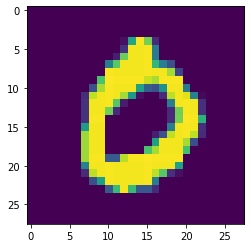

In [44]:
plt.imshow(data_index[0])

In [45]:
len(data_index)

100

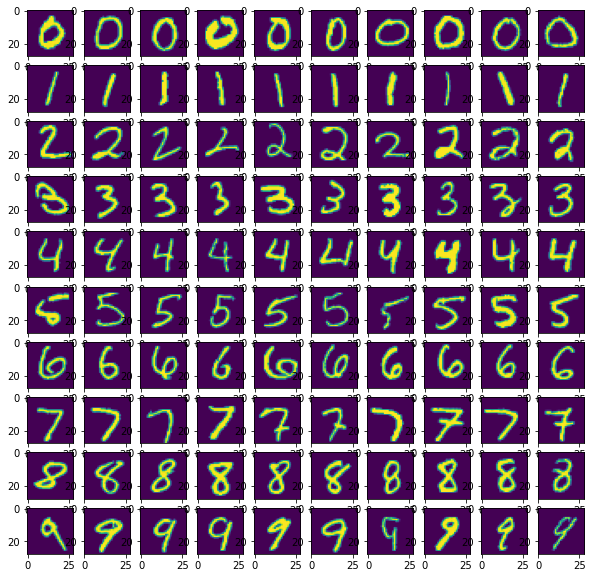

In [46]:
fig, ax = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(data_index[i*10+j])
        
plt.show()

Now that we have all the images in the right order

*   Convert each image into tiles 
*   Use tiles for prediction 
*   store the prediction in numpy dataformat
*   visualize them again





In [47]:
image_tiles = []
for i in range(data_index.shape[0]):
    image_tiles.append(image_patches(data_index[i,:,:]))
data_index_tiles = np.array(image_tiles)
print(data_index_tiles.shape)

(100, 16, 7, 7)


In [48]:
data_index_tiles = tf.reshape(data_index_tiles,shape=(100,16,49))

In [49]:
# tiles = tf.expand_dims(tiles,axis=0)
# for i in range(8):
#   pred = model.predict(tiles)
#   tiles = np.concatenate((tiles, pred[:,-1,:].reshape(1,1,49)),axis = 1)

InvalidArgumentError: ignored

In [52]:
def generate_images(pic):
  pred = pic[0:8,:].numpy().reshape(1,8,49)
  for i in range(8):
    y_pred = model.predict(pred)
    pred = np.concatenate((pred, y_pred[:,-1,:].reshape(1,1,49)),axis = 1)
  return pred



In [54]:
data_new = np.zeros((100,16,49))


for i in range(10):
  for j in range(10):
    data_new[i*10+j] = generate_images(data_index_tiles[i*10+j])


1/1 [==============================] - 0s 16ms/step


In [58]:
data_new.shape

(100, 16, 49)

In [66]:
data_new[0].shape

(16, 49)

##Final Output of image reconstruction

In [83]:
def img_reshape(pic):
  recreated_image = np.zeros((28,28))
  count = 0
  pic = np.expand_dims(pic,axis=0)
  #print(pic.shape)
  for i in range(4):
    for j in range(4):
      recreated_image[i*7:i*7+7,j*7:j*7+7] = pic[0,count].reshape(7,7)
      count+=1
  return(recreated_image)


In [84]:
data_new_img = np.zeros((100,28,28))
for i in range(10):
  for j in range(10):
    data_new_img[i*10+j] = img_reshape(data_new[i*10+j])

In [56]:
# data_new1 = tf.reshape(data_new,shape=(100,28,28))

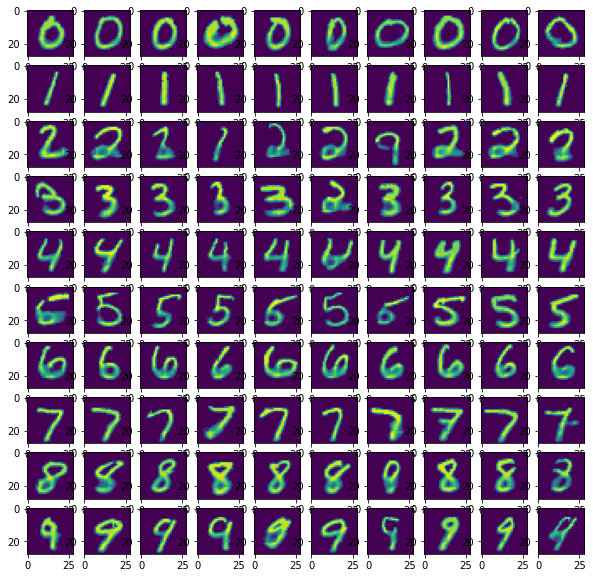

In [86]:
fig, ax = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(data_new_img[i*10+j])
        
plt.show()

##CHECK of image

In [79]:
data = data_new[0]
data = np.expand_dims(data, axis=0)

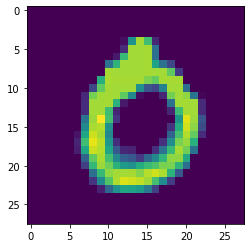

In [80]:
recreated_image = np.zeros((28,28))
count = 0
for i in range(4):
    for j in range(4):
        recreated_image[i*7:i*7+7,j*7:j*7+7] = data[0,count].reshape(7,7)
        count+=1
plt.imshow(recreated_image)